*Desafio-Prediciendo las ventas de una tienda.*

#**0.Importamos librerias**

In [2]:
!pip install pmdarima #importante,
import pandas as pd
import numpy as np
#Visualización
import matplotlib.pyplot as plt
import seaborn as sns
#Descomposicion de serie de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
#ACF y PACF
from statsmodels.tsa.stattools import acf,pacf #modelos
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf #graficos
#Test de dickey-fuller
from statsmodels.tsa.stattools import adfuller
#Modelos arima
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
#Metricas evaluacion
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error #rse,r2,mae y mape
#Montamos el drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Cargamos el dataset
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Machine Learning/6.Aprendizaje supervisado y no supervisado Parte V/Desafio/Sales_Data.xlsx")

Exploramos un poco

In [4]:
print("Registros, columnas",df.shape)
print("")
print(df.dtypes)
print("")
nulls = df.isna().sum()
print("Cantidad de nulls por columna en el dataset:\n", nulls)

Registros, columnas (48, 2)

Order Date    datetime64[ns]
Sales                float64
dtype: object

Cantidad de nulls por columna en el dataset:
 Order Date    0
Sales         0
dtype: int64


In [5]:
#Tranformamos el index del dataset
dftime = df.set_index("Order Date")

Podemos graficar la serie

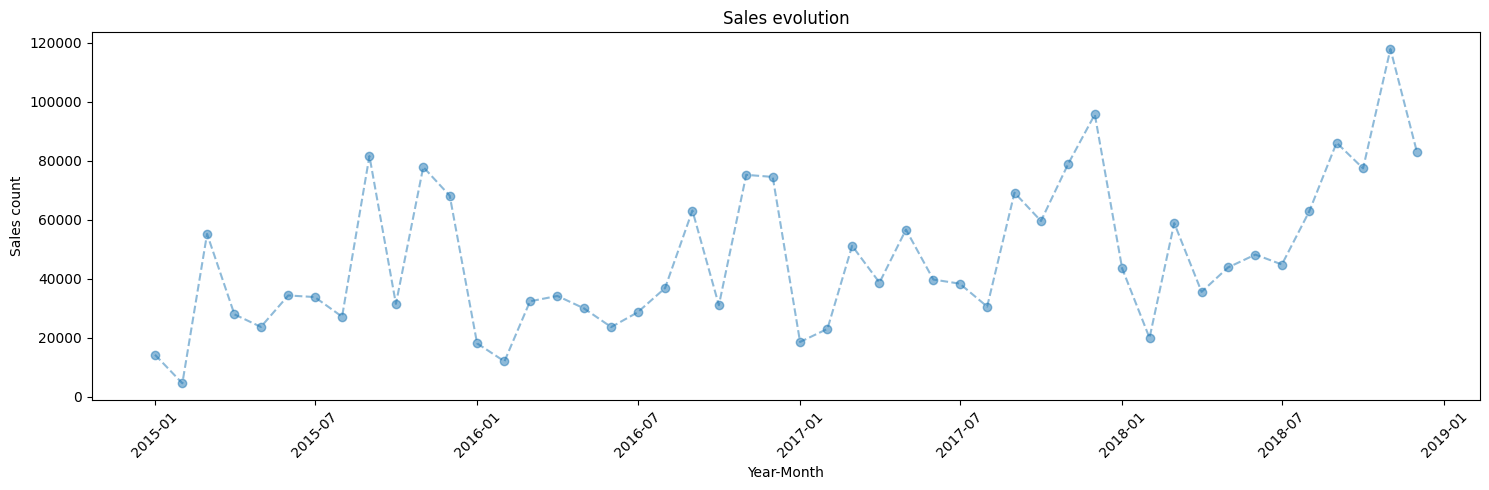

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dftime,alpha=0.5,ls="dashed",marker="o")
plt.title("Sales evolution")
plt.xlabel("Year-Month")
plt.ylabel("Sales count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.Descomposición de la Serie de Tiempo: Comienza descomponiendo la serie de tiempo en sus componentes principales: tendencia, estacionalidad y residuos. Utiliza métodos como el suavizamiento exponencial o la descomposición estacional para comprender la estructura subyacente de los datos.

In [7]:
#Utilizaremos decomposicion temporal para obtener Tendencia, estacionalidad y residuos
result_add = seasonal_decompose(dftime,model="additive")
result_multi = seasonal_decompose(dftime,model="multiplicative")

trend_add, trend_multi = result_add.trend , result_multi.trend
seasonal_add, seasonal_multi = result_add.seasonal , result_multi.seasonal
residual_add, residual_multi = result_add.resid , result_multi.resid


Serie con descomposicion additiva

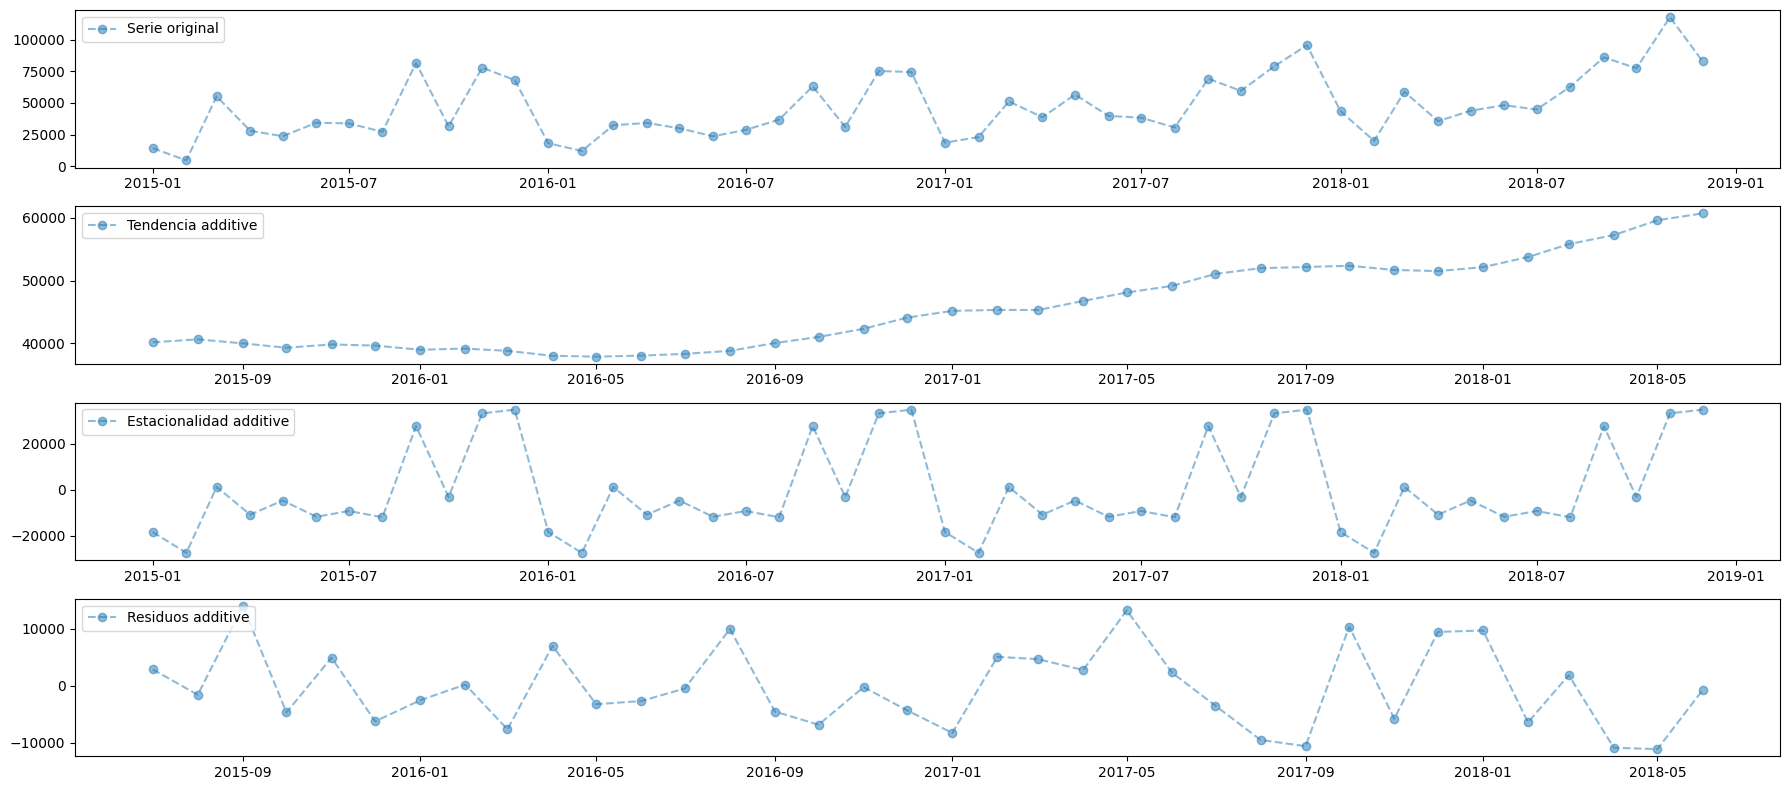

In [8]:
plt.figure(figsize=(18,8))
#Serie original
plt.subplot(411)
plt.plot(dftime,alpha=0.5,ls="dashed",marker="o",label="Serie original")
plt.legend(loc="upper left")
#Tendencia
plt.subplot(412)
plt.plot(trend_add, marker="o",alpha=0.5,ls="dashed",label="Tendencia additive")
plt.legend(loc="upper left")
#Estacionalidad
plt.subplot(413)
plt.plot(seasonal_add, marker="o",alpha=0.5,ls="dashed",label="Estacionalidad additive")
plt.legend(loc="upper left")
#Residuos
plt.subplot(414)
plt.plot(residual_add, marker="o",alpha=0.5,ls="dashed",label="Residuos additive")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

Podemos apreciar una tendencia ascendente clara en el volumen de venta a través de los meses, la cual comienza luego de tocar el punto más bajo en 2016-05.

Con respecto a estacionalidad, se ve como durante los primeros 8 primeros meses, los patrones se repiten: Enero y febrero con el menor numero de ventas, luego 6 meses en donde las ventas se "estabilizan" sin grandes variaciones, para luego desde Septiembre hasta diciembre, un gran alza de estas mismas.

Los residuos por su parte, al no mostrar una estructura o patron claro, confirman que el modelo fue capaz de capturar la estructura de la serie temporal.

**Serie con descomposicion multiplicativa**

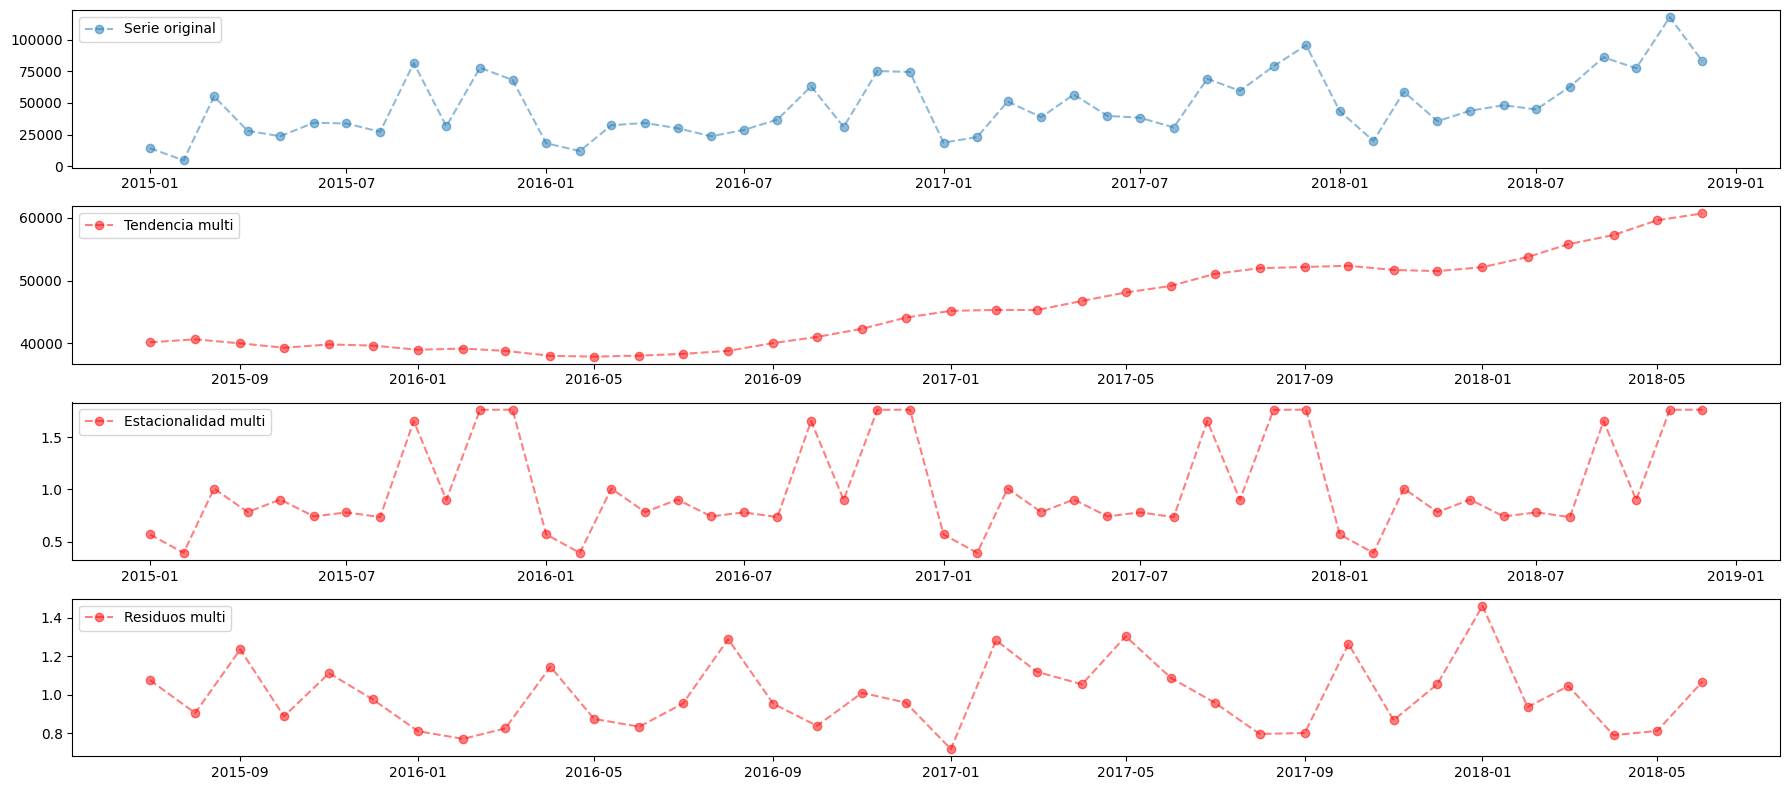

In [9]:
plt.figure(figsize=(18,8))
#Serie original
plt.subplot(411)
plt.plot(dftime,alpha=0.5,ls="dashed",marker="o",label="Serie original")
plt.legend(loc="upper left")
#Tendencia
plt.subplot(412)
plt.plot(trend_multi, marker="o",alpha=0.5,ls="dashed",label="Tendencia multi",color="red")
plt.legend(loc="upper left")
#Estacionalidad
plt.subplot(413)
plt.plot(seasonal_multi, marker="o",alpha=0.5,ls="dashed",label="Estacionalidad multi",color="red")
plt.legend(loc="upper left")
#Residuos
plt.subplot(414)
plt.plot(residual_multi, marker="o",alpha=0.5,ls="dashed",label="Residuos multi",color="red")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

#2.Identificación de Parámetros ARIMA: Utiliza las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF) para identificar los posibles valores de los parámetros p (orden del término autorregresivo) y q (orden del término de media móvil) en el modelo ARIMA. Además, realiza el test de Dickey-Fuller para determinar si es necesario aplicar la diferenciación (valor d) para lograr la estacionaridad.

Busqueda de valor "d", diferenciación a través del test Dicker-Fuller

In [10]:
d=0
p_value = adfuller(dftime)[1] #Nos quedamos con el primer valor que retorna la funcion, esto se aplica sobre la serie de tiempo original
diff_data = dftime #Copia de la serie original

while p_value > 0.05: #Mientras el valor de p no sea estadisticamente significativo
  diff_date = diff_data.diff() #Calcula la dif entre cada valor y su valor anterior
  p_value = adfuller(diff_data.dropna())[1] #Calculo del valor de p para la prueba adf para la serie de tiempo diferenciada, se eliminan los nulos, si los hubiera, pero en este caso no hay.
  d+= 1 #Se suma un valor a cada vuelta del ciclo


print(f"P value :", p_value)
print(f"Differencing Needed:", d)

P value : 0.00027791039276670623
Differencing Needed: 0


Busqueda de valores p y q a través de función de autocorrelacion global ACF y autocorrelacion parcial PACF.

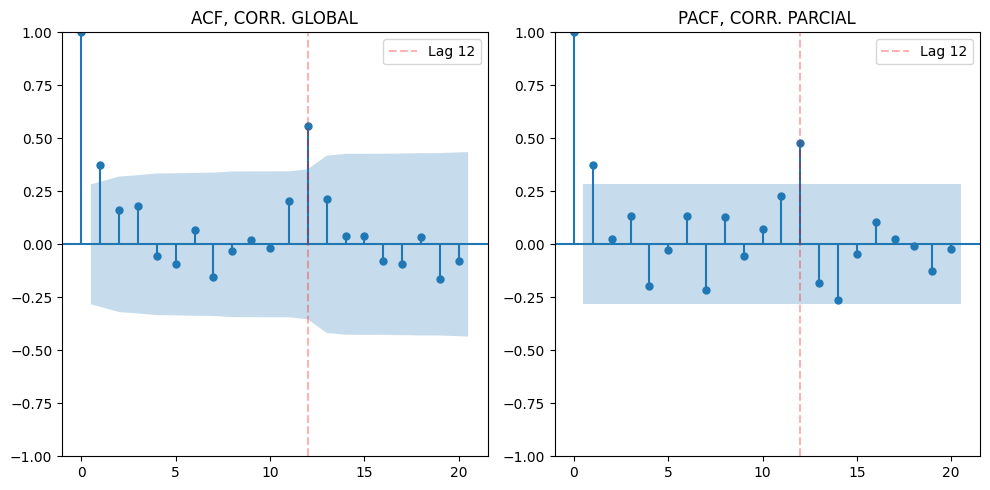

In [11]:
fig,axes = plt.subplots(1,2, figsize=(10,5))

plot_acf(dftime, lags=20, title="ACF, CORR. GLOBAL", alpha=0.05, ax=axes[0])
axes[0].axvline(x=12,ls="dashed",color="red",alpha=0.3,label="Lag 12")
axes[0].legend()
plot_pacf(dftime, lags=20, title="PACF, CORR. PARCIAL", alpha=0.05, ax=axes[1])
axes[1].axvline(x=12,ls="dashed",color="red",alpha=0.3,label="Lag 12")
axes[1].legend()
plt.tight_layout()
plt.show()

En ambos seleccionaremos el ultimo rezago (12), ya que es lo suficientemente significativo pero no muy alto como para inducir overfitting.

#3.Modelado con ARIMA: Aplica el modelo ARIMA utilizando los parámetros identificados en el paso anterior. Ajusta el modelo a los datos históricos de ventas mensuales y realiza predicciones para los próximos meses y 4.Evaluación de Predicciones: Divide los datos históricos en un conjunto de entrenamiento y uno de prueba. Utiliza el conjunto de entrenamiento para ajustar el modelo ARIMA y luego evalúa las predicciones en el conjunto de prueba. Calcula (MSE) o (MAE)

In [12]:
#A partir de ACF, orden del término de medias moviles
q= 12
#A partir de PACF,orden del término autoregresivo
p= 12
#A partir de dickey-fuller
d=0

In [13]:
#Instanciamos los modelos AR y MA separados primero y luego ARIMA
model_ar = ARIMA(dftime,order=(p,0,0)).fit() #autoregresivo
model_ma = ARIMA(dftime,order=(0,0,q)).fit() #medias moviles
model_arima = ARIMA(dftime,order=(p,d,q)).fit()

#Hacemos predicciones sobre los mismos periodos
pred_ar = model_ar.predict(start=p,end=len(dftime)-1, dynamic=False)
pred_ma = model_ma.predict(start=q,end=len(dftime)-1, dynamic=False)
pred_arima = model_arima.predict(start=d,end=48+6)

#Hacemos predicciones sobre 6 meses más
n= 6 #Cantidad de meses
ar_pred_six = model_ar.predict(start=48,end=48+n)
ma_pred_six = model_ma.predict(start=48,end=48+n)

#Combinar los el df para visualizar correctamente
pred_ar = pd.DataFrame({"Sales":pred_ar.values}, index=pred_ar.index)
df_pred_ar = pd.DataFrame({"Sales":ar_pred_six.values}, index=ar_pred_six.index)
df_pred_ar_six = pd.concat([pred_ar,df_pred_ar],axis=0)

pred_ma = pd.DataFrame({"Sales":pred_ma.values}, index=pred_ma.index)
df_pred_am = pd.DataFrame({"Sales":ma_pred_six.values}, index=ma_pred_six.index)
df_pred_am_six = pd.concat([pred_ma,df_pred_am],axis=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred

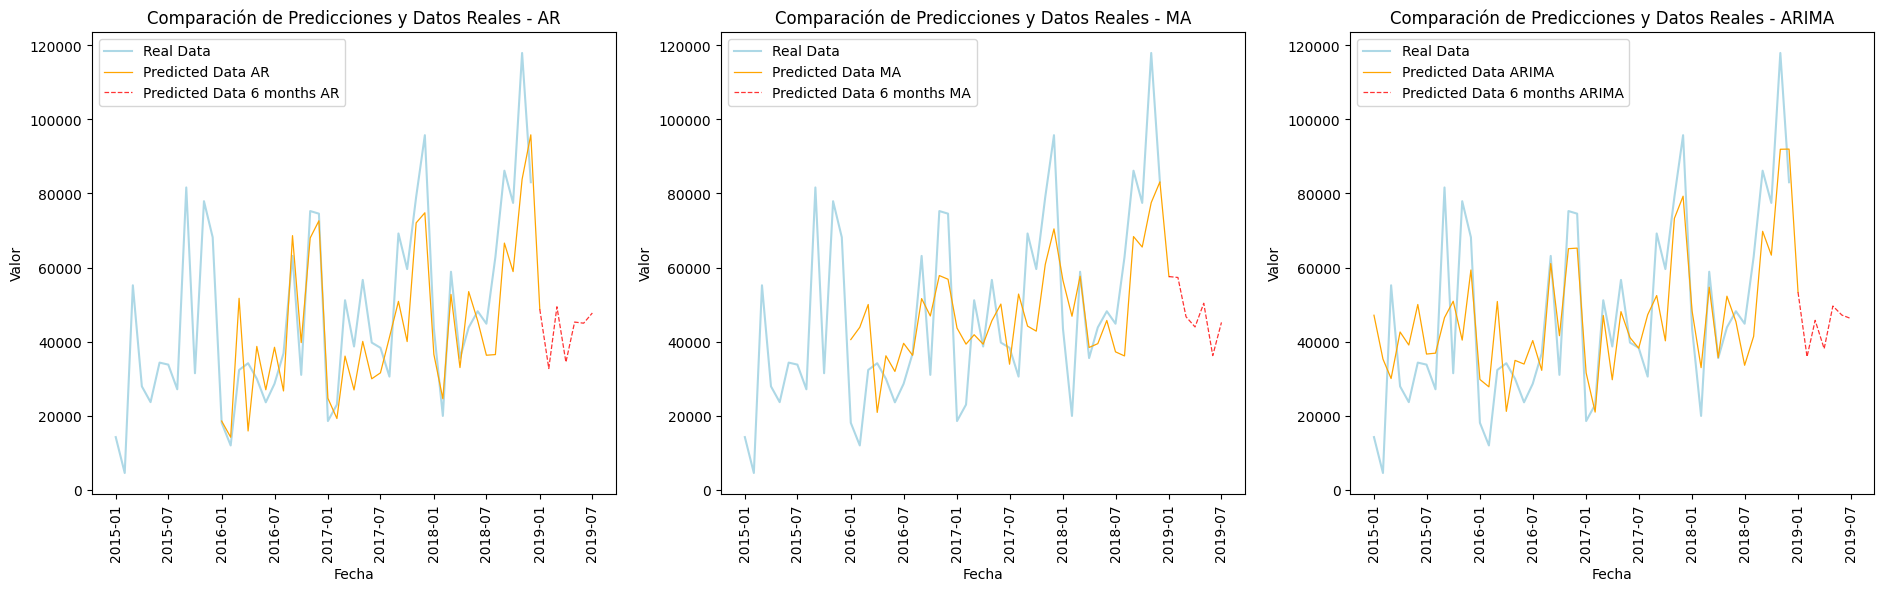

In [14]:
# Crear una figura con dos subplots en una fila
fig, axes = plt.subplots(1, 3, figsize=(23, 6))

#Necesitamos agregar las fechas para los proximos 6 meses
ultima_fecha = dftime.index[-1] #D
nuevas_fechas = pd.date_range(start=ultima_fecha,periods=6, freq="M")

# Subplot 1 - Auto regresivo
axes[0].plot(dftime.index, dftime['Sales'], label='Real Data',color="lightblue")
axes[0].plot(df_pred_ar_six.index[:37], df_pred_ar_six["Sales"][:37], label='Predicted Data AR',color="orange",lw=0.9)
axes[0].plot(df_pred_ar_six.index[36:], df_pred_ar_six["Sales"][36:], label='Predicted Data 6 months AR', color="red", lw=0.9, ls="dashed",alpha=0.8)
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Valor')
axes[0].set_title('Comparación de Predicciones y Datos Reales - AR')
axes[0].tick_params(axis="x",rotation=90)
axes[0].legend()

# Subplot 1 - Medias moviles
axes[1].plot(dftime.index, dftime['Sales'], label='Real Data',color="lightblue")
axes[1].plot(df_pred_am_six.index[:37], df_pred_am_six["Sales"][:37], label='Predicted Data MA',color="orange",lw=0.9)
axes[1].plot(df_pred_am_six.index[36:], df_pred_am_six["Sales"][36:], label='Predicted Data 6 months MA', color="red", lw=0.9, ls="dashed",alpha=0.8)
axes[1].set_xlabel('Fecha')
axes[1].set_ylabel('Valor')
axes[1].set_title('Comparación de Predicciones y Datos Reales - MA')
axes[1].tick_params(axis="x",rotation=90)
axes[1].legend()

# Subplot 1 - ARIMA
axes[2].plot(dftime.index, dftime['Sales'], label='Real Data',color="lightblue")
axes[2].plot(pred_arima.index[:49], pred_arima[:49], label='Predicted Data ARIMA',color="orange",lw=0.9)
axes[2].plot(pred_arima.index[48:], pred_arima[48:], label='Predicted Data 6 months ARIMA', color="red", lw=0.9, ls="dashed",alpha=0.8)
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Valor')
axes[2].set_title('Comparación de Predicciones y Datos Reales - ARIMA')
axes[2].tick_params(axis="x",rotation=90)
axes[2].legend()

Tanto como el modelo autoregresivo como el de medias moviles, comienzan con las predicciones a partir del periodo 12, ya que ese es el numero que se calculó tanto en ACF y PACF, en cambio como el test de dickey fuller indicó que la serie ya era estacionaria y no debia restarse ninguna vez consigo misma, comienza desde el periodo 0.

Se realizaron predicciones a 6 meses para cada uno de los modelos solo para ver como se comportan, ya que solo se solicitó arima. Ahora procederemos a realizar el punto 4.

In [15]:
#Dividiremos el dataset original en train y test, para eso primero debemos definir el index de corte según el % de train-test que queremos
train_size = 0.8
#Buscamos el index para hacer el split
split_index = int(len(dftime)*train_size)
#Dividimos
train_data = dftime[:split_index]
test_data = dftime[split_index:]

#Instanciamos y ajustamos el modelo ARIMA y AUTOARIMA
arima_final = ARIMA(train_data,order=(p,d,q)).fit()
auto_arima = auto_arima(train_data,seasonal=True,m=12) #12 por periodo durante cada estacion

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
#Realizamos las predicciones sobre train
forecast_arima_train = arima_final.forecast(steps=len(train_data))
forecast_auto_arima_train = auto_arima.predict(n_periods=len(train_data))

#Realizamos las predicciones sobre test
forecast_arima_test = arima_final.forecast(steps=len(test_data))
forecast_auto_arima_test = auto_arima.predict(n_periods=len(test_data))

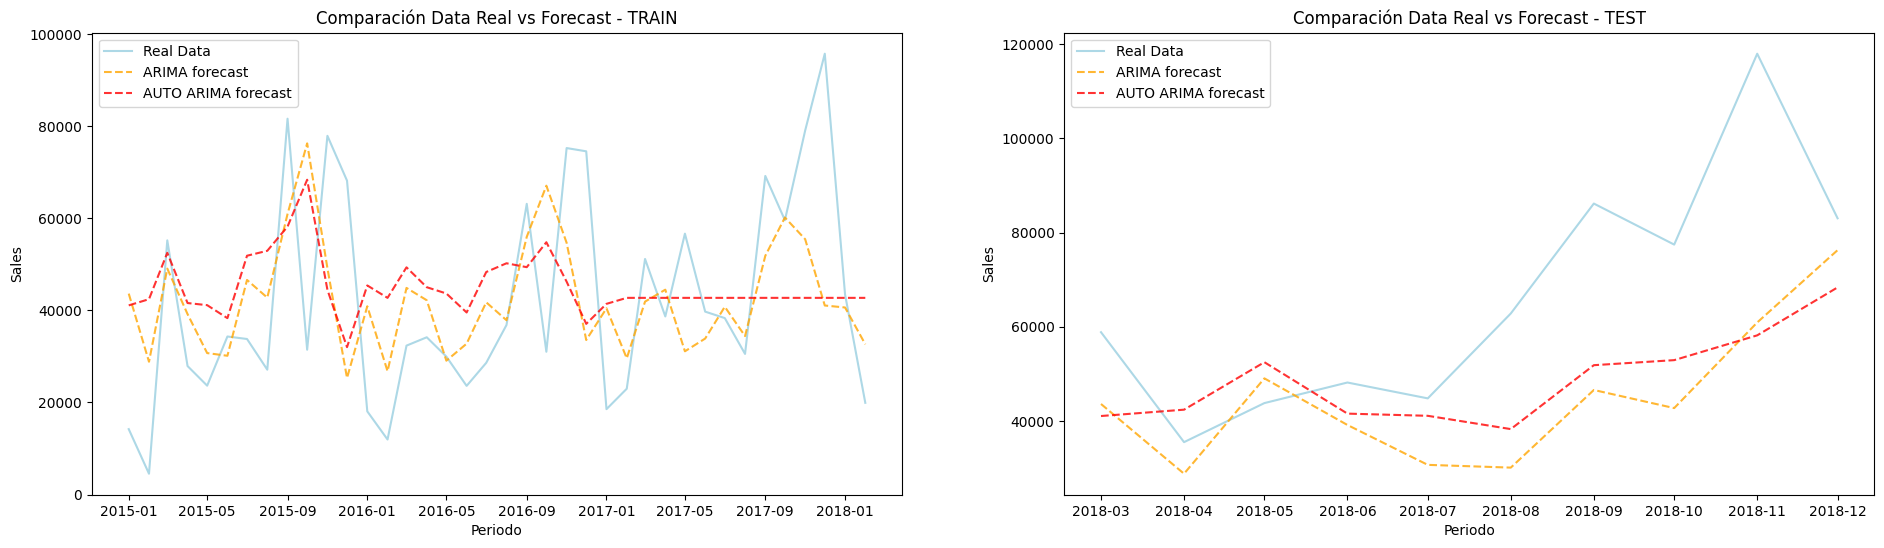

In [17]:
# Creamos un grafico comparativo de TRAIN y TEST
fig, axes = plt.subplots(1, 2, figsize=(23, 6))

#Grafico de train
axes[0].plot(train_data.index,train_data["Sales"],label="Real Data",color="lightblue")
axes[0].plot(train_data.index,forecast_arima_train,label="ARIMA forecast",color="orange",ls="dashed",alpha=0.8)
axes[0].plot(train_data.index,forecast_auto_arima_train,label="AUTO ARIMA forecast",color="red",ls="dashed",alpha=0.8)
axes[0].set_title("Comparación Data Real vs Forecast - TRAIN")
axes[0].set_xlabel("Periodo")
axes[0].set_ylabel("Sales")
axes[0].legend()

#Grafico de test
axes[1].plot(test_data.index,test_data["Sales"],label="Real Data",color="lightblue")
axes[1].plot(test_data.index,forecast_arima_test,label="ARIMA forecast",color="orange",ls="dashed",alpha=0.8)
axes[1].plot(test_data.index,forecast_auto_arima_test,label="AUTO ARIMA forecast",color="red",ls="dashed",alpha=0.8)
axes[1].set_title("Comparación Data Real vs Forecast - TEST")
axes[1].set_xlabel("Periodo")
axes[1].set_ylabel("Sales")
axes[1].legend()

Evaluaremos los modelos con 3 métricas

In [18]:
y_true_train = train_data["Sales"]
y_true_test = test_data["Sales"]

def get_metrics (y_true,y_pred):
  mse = mean_squared_error(y_true,y_pred)
  rmse = np.sqrt(mse)
  r2= r2_score(y_true,y_pred)
  return {"MSE": round(mse,2), "RMSE":round(rmse,2), "r2":round(r2,2)}

In [19]:
ev_arima_train = get_metrics(y_true_train,forecast_arima_train)#Evaluacion ARIMA TRAIN
ev_autoarima_train = get_metrics(y_true_train,forecast_auto_arima_train)#Evaluacion AUTOARIMA TRAIN

In [20]:
ev_arima_test = get_metrics(y_true_test,forecast_arima_test) #Evaluacion ARIMA TEST
ev_autoarima_test = get_metrics(y_true_test,forecast_auto_arima_test)#Evaluacion AUTOARIMA TEST

In [29]:
#Visualizamos las evaluaciones de TRAIN y TEST
print("="*100)
print("METRICAS EVALUACION MODELO ARIMA EN TRAIN:")
print(ev_arima_train)

print("")
print("METRICAS EVALUACION MODELO AUTOARIMA EN TRAIN:")
print(ev_autoarima_train)
print("")
print("="*100)
print("METRICAS EVALUACION MODELO ARIMA EN TEST:")
print(ev_arima_test)
print("")
print("METRICAS EVALUACION MODELO AUTO ARIMA EN TEST:")
print(ev_autoarima_test)

METRICAS EVALUACION MODELO ARIMA EN TRAIN:
{'MSE': 453802970.26, 'RMSE': 21302.65, 'r2': 0.1}

METRICAS EVALUACION MODELO AUTOARIMA EN TRAIN:
{'MSE': 556034709.63, 'RMSE': 23580.39, 'r2': -0.11}

METRICAS EVALUACION MODELO ARIMA EN TEST:
{'MSE': 771629536.48, 'RMSE': 27778.22, 'r2': -0.34}

METRICAS EVALUACION MODELO AUTO ARIMA EN TEST:
{'MSE': 665814047.83, 'RMSE': 25803.37, 'r2': -0.15}


Conclusiones finales:
Con un MSE y RMSE tan alto, ambos modelos tienen un error promedio de más de 25000 unidades, lo que para el contexto de la predicción es un valor considerablemente alto y errado, además de esto, ambos valores de r2 negativos nos indican la posibilidad de que ambos modelos basicamente no estan explicando la variabilidad de Sales durante los periodos de tiempo testeados, por lo que se deben estudiar otros algortimos para poder predecir las ventas, o en su defecto obtener más data ya que comparando los rendimientos en train vs test, podemos concluir que el modelo cuenta con un underfitting, de hecho solo viendo el grafico de test, podemos ver como tanto arima como auto arima no son capaces de explicar con precision la variabilidad de Sales, por eso cuando el modelo va a TEST, su desempeño cae considerablemente, ya que no fue entrenado con la cantidad de data adecuada.